In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import time
from IPython import display
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)

In [3]:
class Timer:
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        self.tik = time.time()
    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def sum(self):
        return sum(self.times)

In [4]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [5]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [6]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []

        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [7]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [8]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

In [9]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()            
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    return net

In [10]:
class FacialExpressionDataset(Dataset):
    def __init__(self, csv_path, train=True, readtensor=False, transform=None): #readtensor=True表示跳过前处理，直接读tensor
        if not readtensor:        
            data = pd.read_csv(csv_path)
            if train:            
                data = data[data.Usage=='Training']
                data = data.reset_index(drop=True)
            else:
                data = data[data.Usage=='Test']
                data = data.reset_index(drop=True)
            self.Xlst = []
            self.ylst = []
            self.L = len(data)
            for i in range(self.L):
                xlst = data.loc[i].pixels.split()        
                xlst = [int(x) for x in xlst]
                X = np.array(xlst).reshape([1,48,48])
                y = data.loc[i].emotion
                self.Xlst.append(X)
                self.ylst.append(y)            
            self.Xlst = torch.tensor(self.Xlst,dtype=torch.float32)
            self.ylst = torch.tensor(self.ylst,dtype=torch.int64)
            if train:
                torch.save(self.Xlst, '../data/train_data_Xlst.pt')
                torch.save(self.ylst, '../data/train_data_ylst.pt')
            else:
                torch.save(self.Xlst, '../data/test_data_Xlst.pt')
                torch.save(self.ylst, '../data/test_data_ylst.pt')                    
        else:
            if train:
                self.Xlst=torch.load('../data/train_data_Xlst.pt')
                self.ylst=torch.load('../data/train_data_ylst.pt')
                self.L = len(self.ylst)
            else:
                self.Xlst=torch.load('../data/test_data_Xlst.pt')
                self.ylst=torch.load('../data/test_data_ylst.pt')
                self.L = len(self.ylst)
        
        self.transform = transform

    def __len__(self):
        return self.L

    def __getitem__(self, idx):
        sample = (self.Xlst[idx], self.ylst[idx])
        if self.transform:
            sample = self.transform(sample)
        return (sample)

In [11]:
train_data = FacialExpressionDataset('../data/data.csv', train=True, readtensor=True)
test_data = FacialExpressionDataset('../data/data.csv', train=False, readtensor=True)

In [12]:
# VGG
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 3 * 3, 2048), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(2048, 2048), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(2048, 7))

net = vgg(conv_arch)

# X = torch.randn(size=(1, 1, 48, 48))
# for blk in net:
#     X = blk(X)
#     print(blk.__class__.__name__,'output shape:\t',X.shape)

loss 0.198, train acc 0.932, test acc 0.584
3684.7 examples/sec on cuda:2


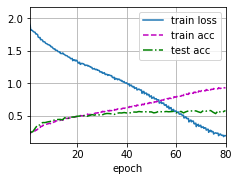

In [14]:
lr, num_epochs, batch_size = 0.001, 80, 64
train_iter = DataLoader(train_data, batch_size, shuffle=True, num_workers=4)
test_iter = DataLoader(test_data, batch_size, shuffle=False, num_workers=4)
final_net = train(net, train_iter, test_iter, num_epochs, lr, torch.device('cuda:2'))

In [15]:
torch.save(final_net, './vgg9net.pkl')